<a href="https://colab.research.google.com/github/MichalMiko6211/stocks_lstm/blob/master/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import bs4
import numpy as np

#Pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler


Let's try to get stooq data for Santnder? 




Create function that would fetch & preprocess data

In [0]:
def get_data(symbol):
  
  
  #Get data from Stooq: 
  
  link = "https://stooq.pl/q/d/l/?s=" + symbol + "&i=d"
  df = pd.read_csv(link)
  
  df.set_index('Data', inplace = True)
  df = df['Zamkniecie']
    
  return df

In [0]:
df = get_data('peo')

In [0]:

# scaler = FeatureUnion([("minmax", MinMaxScaler()),
#                      ("std", StandardScaler())])


scaler = StandardScaler()

data = scaler.fit_transform(df.values.reshape(-1,1))

memory_days = 3


X,Y = [],[]
for i in range(len(data)-memory_days-1):
    X.append(data[i:(i+memory_days),0])
    Y.append(data[(i+memory_days),0])

    
X, y = np.array(X),np.array(Y)


Now, we need to split data into training and test set

In [6]:
X_train,X_test = X[:int(X.shape[0]*0.95)],X[int(X.shape[0]*0.95):]
y_train,y_test = y[:int(y.shape[0]*0.95)],y[int(y.shape[0]*0.95):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

4956
261
4956
261


Actual model building - Keras

In [7]:
from keras.models import Sequential
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [8]:
model = Sequential()
model.add(LSTM(512,input_shape=(3,1)))
model.add(Dense(1))




Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-9, verbose =1)

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=15, verbose=1)

In [0]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [0]:
model.compile(optimizer='adam',loss='mse')

In [12]:
results = model.fit(X_train,y_train,epochs=200, callbacks=[checkpointer, earlystopper, reduce_lr], validation_data=(X_test,y_test),shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 4956 samples, validate on 261 samples
Epoch 1/200
4956/4956 [==============================] - 4s 897us/step - loss: 0.1053 - val_loss: 0.0038

Epoch 00001: val_loss improved from inf to 0.00378, saving model to model.weights.best.hdf5
Epoch 2/200
4956/4956 [==============================] - 1s 282us/step - loss: 0.0054 - val_loss: 0.0039

Epoch 00002: val_loss did not improve from 0.00378
Epoch 3/200
4956/4956 [==============================] - 1s 277us/step - loss: 0.0057 - val_loss: 0.0040

Epoch 00003: val_loss did not improve from 0.00378
Epoch 4/200
4956/4956 [==============================] - 1s 282us/step - loss: 0.0057 - val_loss: 0.0040

Epoch 00004: val_loss did not improve from 0.00378
Epoch 5/200
4956/4956 [==============================] - 1s 287us/step - loss: 0.0057 - val_loss: 0.0041

Epoch 00005: val_loss did not improve from 0.00378
Epoch 6/200
4956/4956 [==============================] - 1s 285us/step - loss: 

In [0]:
import matplotlib.pyplot as plt

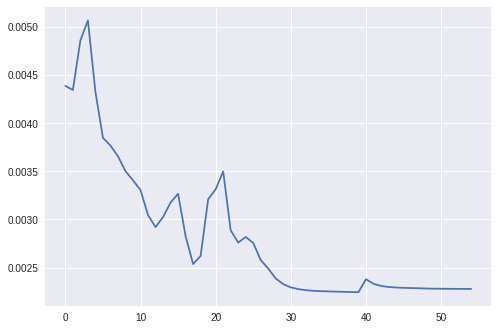

In [0]:
plt.plot(results.history['val_loss'])

In [0]:
Y_hat = model.predict(X_test)

In [0]:
Y_hat[:20]

array([[0.8402747 ],
       [0.8479723 ],
       [0.82309306],
       [0.7574004 ],
       [0.79968655],
       [0.771119  ],
       [0.79596186],
       [0.8446984 ],
       [0.82941926],
       [0.77155876],
       [0.90438974],
       [0.8453369 ],
       [0.78013897],
       [0.7493179 ],
       [0.79127586],
       [0.82764256],
       [0.8466463 ],
       [0.750903  ],
       [0.8215141 ],
       [0.78177357]], dtype=float32)

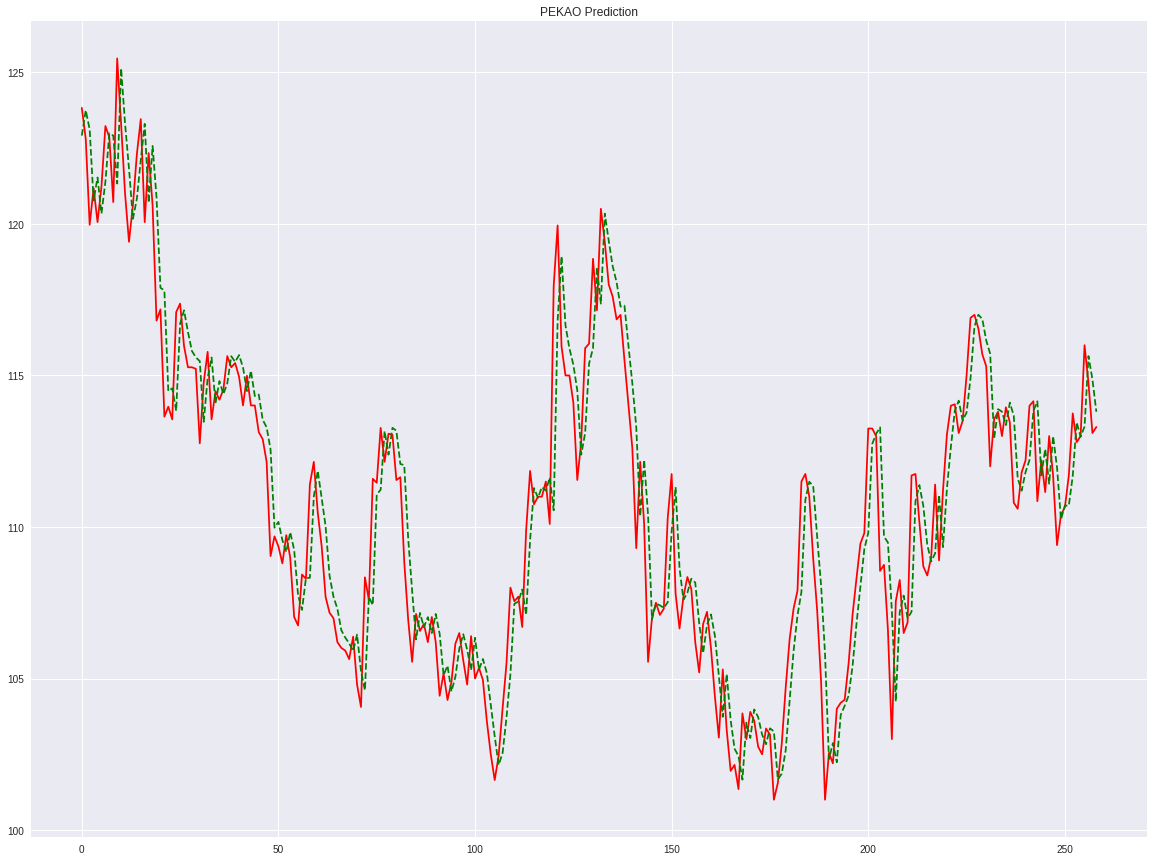

In [0]:
plt.figure(figsize=[20,15])
plt.title("PEKAO Prediction")
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), 'r' )
plt.plot(scaler.inverse_transform(Y_hat), 'g--')
plt.show()

In [0]:
X_test.shape

(259, 5, 1)

In [0]:
X_test[-2]

array([[0.59402713],
       [0.56861673],
       [0.57396629],
       [0.65420964],
       [0.62077491]])

In [0]:
y_test[-1]

0.5819906259103192

In [0]:
last_predicted = model.predict(X_test[-2].reshape(1,5,1))

In [0]:
print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(last_predicted),scaler.inverse_transform(y_test[-3].reshape(-1,1))))

predicted:[[114.68016]], actual:[[114.75]]


In [0]:
df.tail(6)

Data
2019-02-22    113.00
2019-02-25    116.00
2019-02-26    114.75
2019-02-27    113.10
2019-02-28    113.30
2019-03-01    112.50
Name: Zamkniecie, dtype: float64

In [0]:
scaler.inverse_transform(y_test[-5:].reshape(-1,1))

array([[112.8 ],
       [113.  ],
       [116.  ],
       [114.75],
       [113.1 ]])

Predict for the future

In [0]:
df.tail(3)

Data
2019-02-26    114.75
2019-02-27    113.10
2019-02-28    113.30
Name: Zamkniecie, dtype: float64

In [0]:
cl[-3:]

array([[0.66953964],
       [0.65819896],
       [0.65957359]])

In [0]:
scaler.inverse_transform(model.predict(cl[-3:].reshape(1,3,1)))

NameError: ignored

In [0]:
df[-1]

112.5